In [2]:
# import numpy as np
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import re

In [3]:
# Load the dataset (approx. 1000 celebrities's images from Huggingface)
from datasets import load_dataset
ds = load_dataset("tonyassi/celebrity-1000")

In [4]:
# Basic info
print(f"Dataset type: {type(ds)}")
print(f"Dataset keys: {list(ds.keys())}")
print(f"Dataset structure: {ds}")

Dataset type: <class 'datasets.dataset_dict.DatasetDict'>
Dataset keys: ['train']
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 18184
    })
})


In [5]:
# Analyze each split (train, test, validation)
for split_name, split_data in ds.items():
    print(f"Number of samples: {len(split_data)}")
    print(f"Features: {split_data.features}")
    
    # See first few examples
    print(f"\nFirst 3 examples:")
    for i in range(min(3, len(split_data))):
        example = split_data[i]
        print(f"Example {i}:")
        for key, value in example.items():
            if isinstance(value, (list, np.ndarray)):
                print(f"  {key}: {type(value)} with shape {np.array(value).shape}")
            else:
                print(f"  {key}: {value}")
        print()

Number of samples: 18184
Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Aaron Eckhart', 'Aaron Paul', 'Aaron Rodgers', 'Aaron Taylor-Johnson', 'Abbi Jacobson', 'Abhishek Bachchan', 'Abigail Breslin', 'Abigail Spencer', 'Adam Brody', 'Adam Devine', 'Adam Driver', 'Adam Lambert', 'Adam Levine', 'Adam Sandler', 'Adam Scott', 'Adele', 'Adrian Grenier', 'Adèle Exarchopoulos', 'Aidan Gillen', 'Aidan Turner', 'Aishwarya Rai', 'Aja Naomi King', 'Alden Ehrenreich', 'Aldis Hodge', 'Alec Baldwin', 'Alex Morgan', 'Alex Pettyfer', 'Alex Rodriguez', 'Alexander Skarsgård', 'Alexandra Daddario', 'Alfre Woodard', 'Alia Shawkat', 'Alice Braga', 'Alice Eve', 'Alicia Keys', 'Alicia Vikander', 'Alison Brie', 'Allison Janney', 'Allison Williams', 'Alyson Hannigan', 'Amanda Peet', 'Amanda Seyfried', 'Amandla Stenberg', 'Amber Heard', 'America Ferrera', 'Amy Adams', 'Amy Poehler', 'Amy Schumer', 'Ana de Armas', 'Andie MacDowell', 'Andrew Garfield', 'Andrew Lincoln', 'A

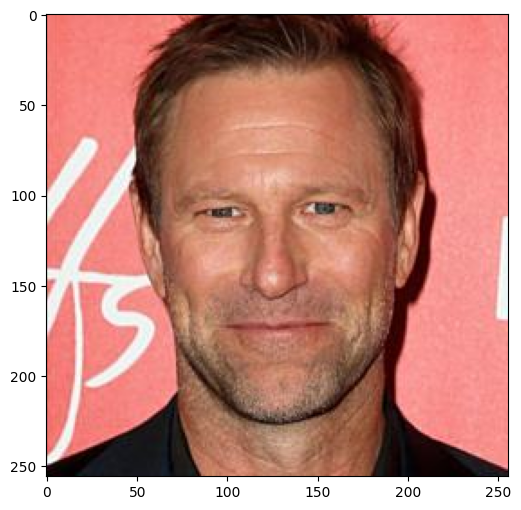

In [6]:
# Display a single image
example = ds['train'][0]
image = example['image']
plt.figure(figsize=(8, 6))
plt.imshow(image)

In [7]:
# See the properties of the image
image.size
image.mode
print(np.array(image).shape)

(256, 256, 3)


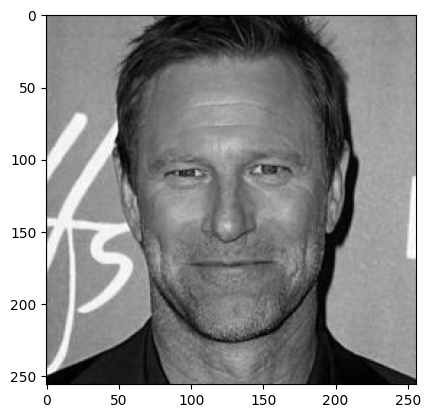

In [8]:
# Convert the image to grayscale
img = np.array(image)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [9]:
# face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

# Use OpenCV to detect faces and eyes
# Get OpenCV data path
opencv_path = cv2.data.haarcascades
face_cascade = cv2.CascadeClassifier(os.path.join(opencv_path, 'haarcascade_frontalface_default.xml'))
eye_cascade = cv2.CascadeClassifier(os.path.join(opencv_path, 'haarcascade_eye.xml'))

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 46,  44, 164, 164]])

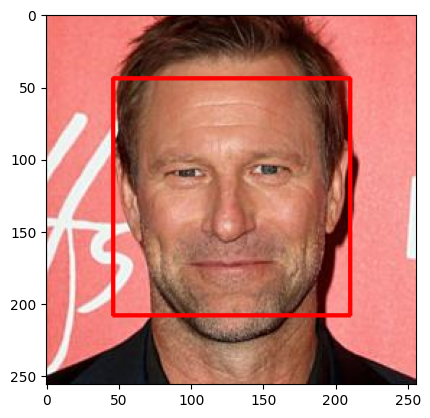

In [10]:
(x,y,w,h) = faces[0]
face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
plt.imshow(face_img)

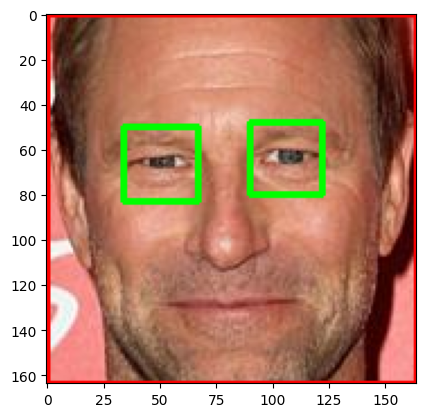

In [ ]:
# Detect faces and eyes
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# Draw rectangles around faces and eyes
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [13]:
# Function to get face and eyes
def get_face_and_eyes(image):
    img = np.array(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [ ]:
# Function to sanitize the filename
def sanitize_filename(name):
    # Replace invalid characters with underscores
    invalid_chars = r'[<>:"/\\|?*]'
    sanitized = re.sub(invalid_chars, '_', name)
    # Remove leading/trailing spaces and dots
    sanitized = sanitized.strip(' .')
    return sanitized

In [ ]:
# Function to process all celebrity images
def process_all_celebrity_images(dataset, output_dir="celebrity_faces_all"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    train_data = dataset['train']
    celebrity_counts = {}
    
    print("Start Processing...")
    
    for i in range(len(train_data)):
        example = train_data[i]
        image = example['image']
        celebrity_name = train_data.features['label'].names[example['label']]
        
        # Sanitize the celebrity name for filesystem
        safe_name = sanitize_filename(celebrity_name)
        cropped_face = get_face_and_eyes(image)
        
        if cropped_face is not None:
            celebrity_dir = os.path.join(output_dir, safe_name)
            if not os.path.exists(celebrity_dir):
                os.makedirs(celebrity_dir)
            
            if safe_name not in celebrity_counts:
                celebrity_counts[safe_name] = 0
            
            face_filename = f"{safe_name}_{celebrity_counts[safe_name]:05d}.jpg"
            face_path = os.path.join(celebrity_dir, face_filename)
            
            cv2.imwrite(face_path, cropped_face)
            
            celebrity_counts[safe_name] += 1
    
    print(f"\nProcessing complete...")
    print(f"Total celebrities: {len(celebrity_counts)}")
    print(f"Total images: {sum(celebrity_counts.values())}")
    
    return celebrity_counts

In [18]:
stats = process_all_celebrity_images(ds)

Start Processing...

Processing complete...
Total celebrities: 995
Total images: 15012
